In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
import pydicom
from pydicom.data import get_testdata_files
from ipywidgets import widgets, Layout
from IPython.display import display

In [15]:
def bresenham(p0, p1):
    pts = []
    x0, y0 = p0
    x1, y1 = p1

    dx = abs(x1-x0)
    dy = abs(y1-y0)
    
    if x0 < x1:
        sx = 1
    else:
        sx = -1
        
    if y0 < y1:
        sy = 1
    else:
        sy = -1
        
    err = dx-dy
    while True:
        pts.append((x0,y0))
        if x0 == x1 and y0 == y1:
            return pts
        
        e2 = 2*err
        if e2 > -dy:
            # overshot in the y direction
            err = err - dy
            x0 = x0 + sx
        if e2 < dx:
            # overshot in the x direction
            err = err + dx
            y0 = y0 + sy
            
            
def rotate_line(line, origin, angle):
    origin_x, origin_y = origin
    rotated_line = []
    for point in line:
        x, y = point
        rotated_x = int(origin_x + math.cos(angle) * (x - origin_x) - math.sin(angle) * (y - origin_y))
        rotated_y = int(origin_y + math.sin(angle) * (x - origin_x) + math.cos(angle) * (y - origin_y))
        rotated_line.append((rotated_x, rotated_y))
    return rotated_line


def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


def add_padding(picture):
    x,y = picture.shape
    b = max(picture.shape)
    new = np.zeros((b*2, b*2))
    new[int(b-x/2): int(b + x/2), int(b -y/2): int(b + y/2)] = picture
    return new

#generates emitters and detectors vertically
def gen_emitters_and_detectors(n, angle, paddImg):
    x2, y2 = paddImg.shape
    x = x2/2
    y = y2/2
    r=math.sqrt(x**2 + y**2)/2
    l = int(2 * (r * math.sin(angle/2) ))
    emitters = [(int(x),int(y2/2 + r)) for x in np.linspace(int(x2/2 - l/2), int(x2/2 + l/2), n)]
    detectors = [(int(x),int(y2/2 - r)) for x in np.linspace(int(x2/2 - l/2), int(x2/2 + l/2), n)]
    return emitters, detectors

def gen_sinogram(n,angle, alphaStepDeg, img):
    gray = rgb2gray(img) / 255
    paddGray = add_padding(gray)
    center = (int(paddGray.shape[0]/2), int(paddGray.shape[1]/2))

    lines = []
    all_lines=[]
    em, det = gen_emitters_and_detectors(n, angle, paddGray)
    for p1,p2 in zip(em, det):
        lines.append(bresenham(p1,p2))
        
    sinogram = np.zeros((n, int(360/alphaStepDeg)))
    i=0
    for alpha in range(0,360,alphaStepDeg):
        rotated = [rotate_line(line, center, (alpha/180)*math.pi) for line in lines]
        for j, line in enumerate(rotated):
            sinogram[j,i] = sum([paddGray[point] for point in line if point[0] < paddGray.shape[0] and point[1] < paddGray.shape[1]])
        i+=1
        all_lines.append(rotated)
        
    sinogram = sinogram / sinogram.max()
    return sinogram, all_lines

def restore_picture(sinogram, lines, picture_shape):
    x,y = picture_shape[0], picture_shape[1]
    b = max(picture_shape)
    restoration = np.zeros((b*2, b*2)) 
    count_matrix = np.zeros((b*2, b*2))
    for i, lines_for_alpha in enumerate(lines):
        for j, line in enumerate(lines_for_alpha):
            for px, py in line:
                if px < restoration.shape[0] and py < restoration.shape[1]:
                    restoration[px,py] += sinogram[j, i]
                    count_matrix[px,py] += 1
    for i in range(len(count_matrix[0])):
        for j in range(len(count_matrix[1])):
            if count_matrix[i][j] != 0:
                restoration[i][j] /= count_matrix[i][j]
    for i in range(restoration.shape[0]):
        for j in range(restoration.shape[1]):
            if restoration[i,j] < 0:
                restoration[i,j] = 0
    return restoration[int(b-x/2):int(b+x/2), int(b-y/2):int(b+y/2)]


def conv1d(X,H):
    m=len(X);
    n=len(H);
    Y = np.zeros(m+n-1)
    for i in range(n + m -1):
        Y[i]=0;
        for j in range(m):
            if i-j+1>0 and i-j+1<len(H):
                Y[i]=Y[i]+X[j]*H[i-j+1]
    return Y

def conv1d_simple(sinus, simple_kernel):
    copy = sinus.copy()
    for i in range(1,len(sinus)-1):
        copy[i] = simple_kernel[0]*sinus[i-1] + simple_kernel[1] *sinus[i] + simple_kernel[2]*sinus[i+1]
    return copy


def genKernel(size):
    kernel = []
    for i in range(-int(size/2), int(size/2)):
        if i == 0:
            kernel.append(1)
        elif i % 2 == 0:
            kernel.append(0)
        else:
            kernel.append((-4/(math.pi**2))/i**2)    
    return kernel

def convolve_sinogram(sinogram):
    copy = np.zeros(sinogram.shape)
    for i in range(sinogram.shape[1]):
        convolution = conv1d(sinogram[:,i], genKernel(len(sinogram[:,i])))
        convolution = np.append(convolution, 0)
        copy[:,i] = convolution.reshape(-1, 2).mean(axis=1)
    return copy


def convolve_simple(sinogram, simple_kernel):
    copy = np.zeros(sinogram.shape)
    for i in range(sinogram.shape[1]):
        convolution = conv1d_simple(sinogram[:,i], simple_kernel)
        copy[:,i] = convolution
    return copy

def filter_normalize(img, perc=1):
        max = np.percentile(img, 100-perc)
        min = np.percentile(img, perc)
        norm = (img - min) / (max - min)
        norm[norm[:,:] > 255] = 255
        norm[norm[:,:] < 0] = 0
        return norm

Text(value='img/hgw.jpg', placeholder='filename')

Button(button_style='success', description='Run', style=ButtonStyle())

Reading an image...
Generating sinogram...


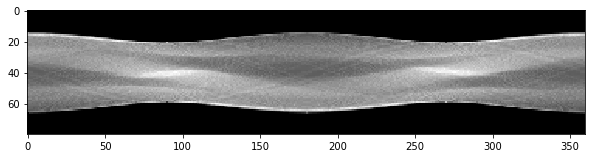

Performing convolution


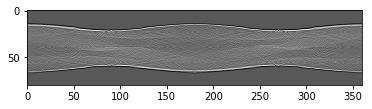

Performing backprojection
100


In [37]:
filename_text = widgets.Text(
    placeholder='filename',
    disabled=False,
    value='img/hgw.jpg'
)

run_button = widgets.Button(
    description='Run',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
)

def showImg(img):
    plt.imshow(img, cmap='gray')
    plt.show()

def perform(arg):
    fig = plt.figure(figsize=(10, 10))
    print("Reading an image...")
    img = plt.imread(filename_text.value)
    img = cv2.resize(img,(100,100))
    print("Generating sinogram...")
    sinogram, lines = gen_sinogram(80, math.pi, 1, img)
    showImg(sinogram)
    print("Performing convolution")
    copy = convolve_simple(sinogram, [-2,5,-2])
    showImg(copy)
    print("Performing backprojection")
    restored = restore_picture(copy, lines, img.shape)
    restored = filter_normalize(restored, perc=30)
    showImg(restored)

display(filename_text)
display(run_button)
run_button.on_click(perform)


